(tut_iau2006)=

# Introduction to the IAU2000/2006 precession-nutation theory

```{versionadded} 7.3.0

```

heyoka.py provides an implementation of the [IAU2000/2006](https://www.aanda.org/articles/aa/abs/2006/45/aa5897-06/aa5897-06.html) precession-nutation theory. [Precession](https://en.wikipedia.org/wiki/Axial_precession) and [nutation](https://en.wikipedia.org/wiki/Astronomical_nutation) are periodic variations in the orientation of the Earth's rotational axis caused by the gravitational forces of the Sun and the Moon, and to a lesser extent other bodies.

IAU2000/2006 consists of a set of analytical formulae representing the three angles $X$, $Y$ and $s$ as a function of time.

$X$ and $Y$ are the celestial intermediate pole (CIP) coordinates in the [International Celestial Reference System (ICRS)](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_its_realizations). They describe the position of the CIP relative to the Geocentric Celestial Reference Frame (GCRF), which is aligned with the ICRS.

$s$ is the Celestial Intermediate Origin (CIO) locator. It represents an additional rotation in the transformation between celestial and terrestrial reference frames.

For more information about these quantities, please consult standard references such as Vallado's "Fundamentals of Astrodynamics" (Chapter 3) and Chapter 5 of the [IERS conventions](https://www.iers.org/SharedDocs/Publikationen/EN/IERS/Publications/tn/TechnNote36/tn36.pdf?__blob=publicationFile&v=1).

## API overview

The {py:func}`heyoka.model.iau2006()` function returns analytical expressions for the $X$, $Y$ and $s$ angles as functions of the input time. The angles are returned in radians.

## Precision and truncation threshold

The IAU2000/2006 theory is formulated as a set of large trigonometric series whose numerical coefficients decay exponentially. By dropping the smaller terms from the series, the precision of the theory degrades but computational efficiency improves. By default, {py:func}`~heyoka.model.iau2006()` drops all trigonometric terms whose coefficients have a magnitude less than 1 microarcsecond. The truncation threshold can be changed via the ``thresh`` keyword argument (measured in arcseconds). See {ref}`below <tut_iau2006_thresh_eval>` for an analysis of the accuracy of the theory at several truncation levels.

## Time coordinate

Although technically IAU2000/2006 uses [barycentric dynamical time (TDB)](https://en.wikipedia.org/wiki/Barycentric_Dynamical_Time), it is common praxis to use [terrestrial time (TT)](https://en.wikipedia.org/wiki/Terrestrial_Time) instead - the two timescales are sufficiently close so as not to introduce any noticeable error in the solutions. Time is measured in Julian centuries from J2000 (JD2451545.0).

By default, {py:func}`~heyoka.model.iau2006()` uses {py:attr}`heyoka.time` to represent the time variable in the IAU2000/2006 formulae. This means that, by default, when the IAU2000/2006 solution is used in an ODE system, time is assumed to be measured in hundreds of Julian years and $t = 0$ corresponds to the Julian date $2451545.0$.

It is possible to change the expression used to represent the time variable in the IAU2000/2006 solution via the ``time_expr`` keyword argument. This allows to rescale and change the origin of time in the IAU2000/2006 formulae.

For instance, if we want time to be measured in Julian days (rather than centuries) since J2000, we can write:

In [9]:
import heyoka as hy

hy.model.iau2006(time_expr=hy.time / 36525.0);

In a similar fashion, we can change the origin of the time coordinate by adding/subtracting an offset to {py:attr}`heyoka.time`. For instance, if we want to be able to use directly the Julian date as time variable (rather than the number of Julian days since J2000), we can write:

In [10]:
hy.model.iau2006(time_expr=(hy.time - 2451545.0) / 36525.0);

Note that the time expression passed to the {py:func}`~heyoka.model.iau2006()` function does not need to be based on {py:attr}`heyoka.time` - in fact *any* expression can be used as a time coordinate in the IAU2000/2006 formulae.

(tut_iau2006_thresh_eval)=

## Truncation threshold and accuracy

In this section, we will provide an assessment of the effect of the truncation threshold on the accuracy of the theory.

We begin by introducing a [compiled function](<./compiled_functions.ipynb>) for the evaluation of the full theory (i.e., without truncation):

In [11]:
# Create a heyoka variable for representing time.
tm = hy.make_vars("tm")

# Construct a compiled function for the full theory.
# We use the Julian date as a time coordinate.
cf_full = hy.cfunc(
    hy.model.iau2006(time_expr=(tm - 2451545.0) / 36525.0, thresh=0.0),
    [tm],
    compact_mode=True,
)

heyoka.py's implementation of the full theory has been validated against the standard [ERFA/SOFA](https://github.com/liberfa/erfa/) routines.

Next, we define a timespan of Julian dates at which we will be evaluating the theory:

In [31]:
import numpy as np

# We will perform 1000 evaluations of the theory
# in the 10 years following J2000.
dates = np.linspace(2451545.0, 2451545.0 + 365.25 * 10, 1000)

We can now proceed to evaluate the full theory over the timespan:

In [32]:
# Evaluate the full theory.
full_eval = cf_full([dates])

Finally, we will be evaluating the theory at several nonzero truncation levels and compare the results with the full theory:

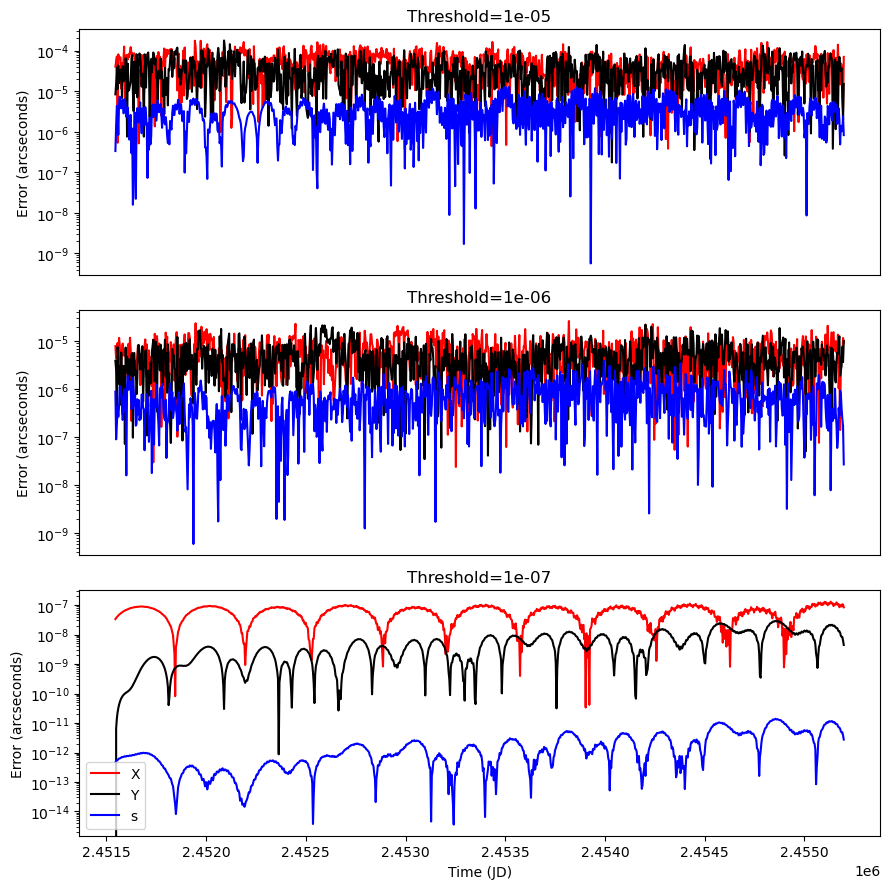

In [33]:
%matplotlib inline
from matplotlib.pylab import plt
import numpy as np

# Setup the plot.
fig = plt.figure(figsize=(9, 9))

# Threshold levels at which we will be computing
# the IAU2000/2006 solution.
thr_values = [1e-5, 1e-6, 1e-7]

for idx, thr in enumerate(thr_values):
    # Build the IAU2000/2006 theory, using the Julian
    # date as a time coordinate and setting the threshold
    # level.
    X, Y, s = hy.model.iau2006(time_expr=(tm - 2451545.0) / 36525.0, thresh=thr)

    # Compile the function for the evaluation of
    # the truncated theory.
    cf = hy.cfunc([X, Y, s], [tm], compact_mode=True)

    # Run the evaluation.
    X_Y_s_values = cf([dates])

    # Compute the difference wrt the full theory in
    # arcseconds.
    diff = np.abs(full_eval - X_Y_s_values) * 180 * 3600 / np.pi

    # Plot.
    plt.subplot(len(thr_values), 1, idx + 1)
    plt.yscale("log")
    plt.plot(dates, diff[0], "r", label="X")
    plt.plot(dates, diff[1], "k", label="Y")
    plt.plot(dates, diff[2], "b", label="s")

    ax = plt.gca()
    ax.set_title(f"Threshold={thr}")

    if idx == 2:
        plt.xlabel("Time (JD)")
        plt.legend()
    else:
        plt.xticks([])
    plt.ylabel("Error (arcseconds)")

plt.tight_layout();

We can clearly see the effects of the truncation threshold on the accuracy of the theory with respect to the full solution. For reference, an error of $10^{-3}$ arcseconds translates on the Earth's surface to a positional error of circa 3 centimeters.